<a href="https://colab.research.google.com/github/nzl-thu/PRMLTA/blob/main/cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# A Gentle Introduction to ``torch.autograd``

``torch.autograd`` is PyTorch’s automatic differentiation engine that powers
neural network training. In this section, you will get a basic sense of how ``autograd`` collects gradients.


In homework 8, you have encountered some matrix calculus equations. For example:

\begin{align}&\frac{\partial}{\partial{X}}\mathrm{\text{Tr}}((Y-CX)^T(Y-CX))=-2 C^T (Y-CX)\end{align}

Now, let's see how we can perform this gradient calculation using pytorch's autograd mechanics (**without** the need of knowing the explicit formula of the gradient).




We first create the matrix ``X``, ``C`` and ``Y``. Note that we pass ``requires_grad=True`` when creating matrix ``X``. This signals to ``autograd`` that every operation on them should be tracked.

In [2]:
import torch
X = torch.randn(4, 4, requires_grad=True)
C = torch.randn(4, 4)
Y = torch.randn(4, 4)

In [3]:
print('expected gradient on X:\n', )
# calculate the result
Q=torch.trace((Y-C @ X).T @ (Y-C.matmul(X)))
# perform back-propagation
Q.backward()
print('autograd calculated gradient on X:\n', X.grad)  # the gradients on X are stored in X.grad 

expected gradient on X:

autograd calculated gradient on X:
 tensor([[-16.1900,  32.3025,  -6.7518,  -2.7811],
        [  5.4551,  -8.1191,   1.0660,  -1.6280],
        [ 23.6524, -12.2436,   5.7600,  -7.5325],
        [ 11.5784, -14.0100,   5.9316,  -0.0560]])


Nice! The gradient calculated by autograd is the same as our analytical solution!

Now, let's re-execute the cell and see what happens!

In [4]:
print('expected gradient on X:\n', -2 * C.T @ (Y - C @ X))
# calculate the result
Q=torch.trace((Y-C @ X).T @ (Y-C.matmul(X)))
# perform back-propagation
Q.backward()
print('autograd calculated gradient on X:\n', X.grad)

expected gradient on X:
 tensor([[-16.1900,  32.3025,  -6.7518,  -2.7811],
        [  5.4551,  -8.1191,   1.0660,  -1.6280],
        [ 23.6524, -12.2436,   5.7600,  -7.5325],
        [ 11.5784, -14.0100,   5.9316,  -0.0560]], grad_fn=<MmBackward0>)
autograd calculated gradient on X:
 tensor([[-32.3799,  64.6050, -13.5036,  -5.5623],
        [ 10.9102, -16.2381,   2.1319,  -3.2559],
        [ 47.3048, -24.4872,  11.5200, -15.0651],
        [ 23.1568, -28.0200,  11.8632,  -0.1120]])


Why in this time the autograd calculated gradient is not the same as our analytical result? This is because every time ``backward()`` function is called, gradients calculated by autograd are **accumulated** into ``X.grad``. 

As a result, if we are only interested in the gradients for current operations, we must first clear previously stored gradients:

In [5]:
print('expected gradient on X:\n', -2 * C.T @ (Y - C @ X))
Q=torch.trace((Y-C @ X).T @ (Y-C.matmul(X)))
X.grad.zero_()  # Important! Clear the previously stored gradients
Q.backward()
print('autograd calculated gradient on X:\n', X.grad)

expected gradient on X:
 tensor([[-16.1900,  32.3025,  -6.7518,  -2.7811],
        [  5.4551,  -8.1191,   1.0660,  -1.6280],
        [ 23.6524, -12.2436,   5.7600,  -7.5325],
        [ 11.5784, -14.0100,   5.9316,  -0.0560]], grad_fn=<MmBackward0>)
autograd calculated gradient on X:
 tensor([[-16.1900,  32.3025,  -6.7518,  -2.7811],
        [  5.4551,  -8.1191,   1.0660,  -1.6280],
        [ 23.6524, -12.2436,   5.7600,  -7.5325],
        [ 11.5784, -14.0100,   5.9316,  -0.0560]])


Works as we expected again!

When performing neural network training, we will see a more principled way of clearing gradients called ``zero_grad``, which will be elaborated later.


# Training a Classifier


## Data Preparation

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [6]:
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


Let us show some of the training images, for fun.



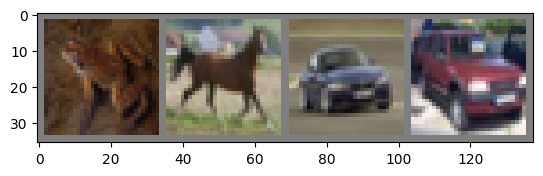

frog  horse car   car  


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Neural Network
Here, we define a simple neural network with 2 hidden layers:



In [43]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 768)
        self.fc2 = nn.Linear(768, 10)
        
    def forward(self, x):
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

net = Net().cuda()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss.
For optimizer, we adopt a highly effective one called Adam. 

Tips: If you are not sure which optimizer to use, try Adam first!

In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [45]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].cuda(), data[1].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

[1,    20] loss: 2.073
[1,    40] loss: 1.822
[1,    60] loss: 1.751
[1,    80] loss: 1.725
[1,   100] loss: 1.757
[1,   120] loss: 1.659
[1,   140] loss: 1.661
[1,   160] loss: 1.640
[1,   180] loss: 1.624
[1,   200] loss: 1.597
[1,   220] loss: 1.617
[1,   240] loss: 1.597
[1,   260] loss: 1.601
[1,   280] loss: 1.537
[1,   300] loss: 1.577
[1,   320] loss: 1.573
[1,   340] loss: 1.540
[1,   360] loss: 1.613
[1,   380] loss: 1.566
[2,    20] loss: 1.471
[2,    40] loss: 1.431
[2,    60] loss: 1.442
[2,    80] loss: 1.475
[2,   100] loss: 1.449
[2,   120] loss: 1.467
[2,   140] loss: 1.499
[2,   160] loss: 1.479
[2,   180] loss: 1.456
[2,   200] loss: 1.385
[2,   220] loss: 1.467
[2,   240] loss: 1.452
[2,   260] loss: 1.465
[2,   280] loss: 1.438
[2,   300] loss: 1.461
[2,   320] loss: 1.424
[2,   340] loss: 1.442
[2,   360] loss: 1.399
[2,   380] loss: 1.433


Let's quickly save our trained model:



In [46]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display images from the test set to get familiar.



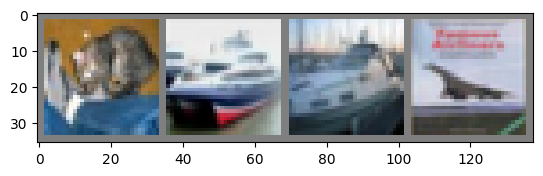

GroundTruth:  cat   ship  ship  plane


In [47]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [48]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [49]:
outputs = net(images)
print("outputs.shape:", outputs.shape)
print("outputs:\n", outputs)

outputs.shape: torch.Size([128, 10])
outputs:
 tensor([[ 0.6741,  0.2208,  1.1422,  ..., -5.2093,  0.9354, -3.3762],
        [ 1.4304,  2.2287, -2.5028,  ..., -3.7320,  5.9397,  4.3387],
        [ 4.2259,  1.6875, -1.1522,  ..., -0.5780,  6.0027,  1.9693],
        ...,
        [-0.2847,  0.2971,  0.7220,  ..., -1.5967, -3.0939, -0.1824],
        [ 1.2484,  0.0241,  0.9041,  ..., -1.3766,  1.8398,  1.6219],
        [-3.5318, -3.5644, -0.3862,  ..., -0.2790, -2.2110, -1.7423]],
       grad_fn=<AddmmBackward0>)


The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [50]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


The results seem ok.

Let us look at how the network performs on the whole dataset.



In [53]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the network on the 10000 test images: 48 %


That looks **way better than chance**, which is 10% accuracy (randomly picking
a class out of 10 classes).
That means the network have already learnt something with this small period of training.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [54]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 57.1 %
Accuracy for class: car   is 51.5 %
Accuracy for class: bird  is 21.6 %
Accuracy for class: cat   is 45.9 %
Accuracy for class: deer  is 31.4 %
Accuracy for class: dog   is 29.2 %
Accuracy for class: frog  is 67.0 %
Accuracy for class: horse is 51.9 %
Accuracy for class: ship  is 72.0 %
Accuracy for class: truck is 54.6 %


Okay, so what next?

## Exercise: Build a more powerful neural network

The previous example is a basic proof of concept of how we can use pytorch to build neural networks. Now it's your turn to build a more powerful neural network!

### ResNet
ResNet is a deep convolutional neural network, uses residual connections to address vanishing gradients and performance degradation in deep networks.

Simply put, the core idea of ResNet is a so called "skip" connection:

\begin{align}\text{without skip}&: y=f(x) \\ \text{with skip}&: y=f(x)+x\end{align}

A ResNet is typically consists of 3 parts: 
1. The first part uses one convolutional layer to project the input images into a feature space.
2. The second part consists of multiple blocks for feature processing.
3. The third part performs a spatial pooling and converts the feature into classification results.
The building block of the second part is the key of ResNet, which is achieved by BasicBlock class.

### Your task: 
Finish the BasicBlock class and perform training & evaluation using your ResNet. Compare how it performs with the previous vannila neural network.

In [55]:
class BasicBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # TODO
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(dim)
        self.conv2 = nn.Conv2d(dim, dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(dim)

    def forward(self, x):
        # TODO
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += x
        out = F.relu(out)
        return out

In [60]:
class ResNet(nn.Module):
    def __init__(self, n_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.blocks = nn.Sequential(*[
            BasicBlock(dim=32) for _ in range(n_blocks)
        ])
        self.linear = nn.Linear(32, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.blocks(out)
        out = F.avg_pool2d(out, 32)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

net = ResNet(n_blocks=6).cuda()


Then, it's time to train & test the performance of your neural network! 

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].cuda(), data[1].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

correct = 0
total = 0
net.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

[1,    20] loss: 2.071
[1,    40] loss: 1.808
[1,    60] loss: 1.700
[1,    80] loss: 1.678
[1,   100] loss: 1.619
[1,   120] loss: 1.557
[1,   140] loss: 1.521
[1,   160] loss: 1.509
[1,   180] loss: 1.424
[1,   200] loss: 1.395
[1,   220] loss: 1.405
[1,   240] loss: 1.392
[1,   260] loss: 1.385
[1,   280] loss: 1.331
[1,   300] loss: 1.307
[1,   320] loss: 1.311
[1,   340] loss: 1.300
[1,   360] loss: 1.228
[1,   380] loss: 1.249
[2,    20] loss: 1.202
[2,    40] loss: 1.201
[2,    60] loss: 1.192
[2,    80] loss: 1.184
[2,   100] loss: 1.196
[2,   120] loss: 1.123
[2,   140] loss: 1.187
[2,   160] loss: 1.126
[2,   180] loss: 1.125
[2,   200] loss: 1.143
[2,   220] loss: 1.081
[2,   240] loss: 1.071
[2,   260] loss: 1.033
[2,   280] loss: 1.078
[2,   300] loss: 1.062
[2,   320] loss: 1.014
[2,   340] loss: 1.043
[2,   360] loss: 1.058
[2,   380] loss: 1.013
Accuracy of the network on the 10000 test images: 61 %
